### 6.1.5 ResNet
- 마이크로소프트에서 개발한 알고리즘.
- "Deep Residual Learning for Image Recognition" 논문에서 발표됨.

**[핵심]**
- 깊어진 신경망을 효과적으로 학습하기 위한 방법으로 Residual(잔차) 개념 고안.
- 네트워크 깊이가 깊다고 해서 무조건 성능이 좋아지지는 않음. => Residual Block 도입 + shortcut(skip connection) 으로 해결.

**[구조]**

- 블록은 계층의 묶음. 즉, 합성곱층을 하나의 블록으로 묶은 것.
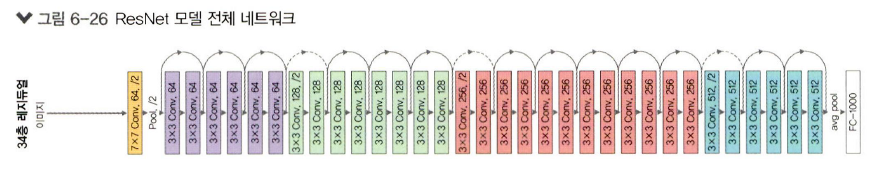
- 색상별로 블록을 구분, 이렇게 묶인 계층들을 하나의 레지듀얼 블록(Residual block)이라고 함.
- 하지만 계층을 계속해서 쌓아 늘리면 파라미터 수가 문제가 됨. (계층 깊어질수록 파라미터 증가)

**[병목 블록]**
- 파라미터 수 증가 문제 해결을 위해 병목 블록(bottleneck block) 사용.
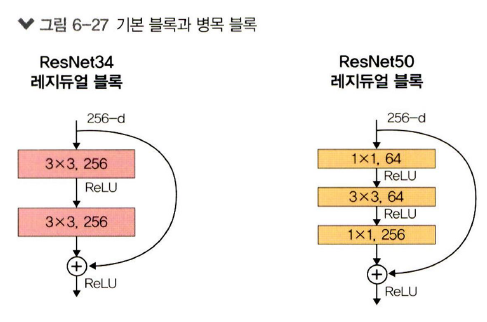
- 기본 블록을 사용한 ResNet34와 병목 블록 사용한 ResNet50 비교했을 때, 기본 블록의 경우 파라미터 수가 39.3216M인 반면, 병목 블록은 6.9632M. => 깊이 깊어졌음에도 파라미터수 감소.
- How? 병목 블록은 3x3 합성곱층 앞뒤로 1x1 합성곱층 붙어 있음. -> 채널 수 조절하면서 차원을 줄였다 늘리는 것 가능하기 때문에 파라미터 수 줄일 수 있음.

**[shortcut 또는 skip connection]**
- 아이덴티티 매핑이라고도 함.
- 입력 x가 어떤 함수를 통과하더라도 다시 x라는 형태로 출력되도록 함.
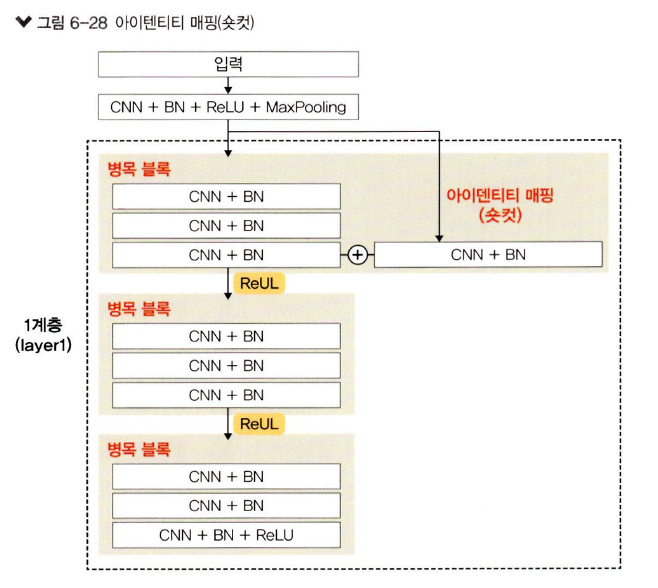

```
def forward(self, x):
    i = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)

    if self.downsample is not None:
        i = self.downsample(i) # 다운샘플 적용

    x += I  # 아이덴티티 매핑 적용
    x = self.relu(x)
    return x

```
- 입력 x를 i라는 변수에 저장.
- 입력 x는 합성곱층 통과하다가 마지막 x에 I 더해 줌.
- x가 (28, 28, 64)로 가정하면, 최종 형태 또한 그대로 (28, 28, 64)가 됨.


**[downsample]**
- 특성맵(feature map) 크기를 줄이기 위한 것. 풀링과 같은 역할.
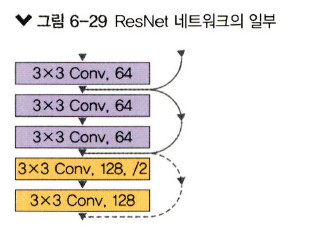
- 보라색 영역의 첫 블록에서 특성 맵 형상이 (28, 28, 64), 세 번째 블록의 마지막 합성곱층 통과하고 아이덴티티 매핑까지 완료한 특성 맵 형상도 (28, 28, 64) 동일.
- 노란색 영역 시작 지점에서는 채널 수가 128로 늘어남, /2 => 첫 블록에서 합성곱층의 스트라이드가 2로 늘어나 (14, 14, 128)로 바뀜.
- 두 영역 간의 형태를 맞추지 않으면 아이덴티티 매핑 불가능. => 따라서 아이덴티티에 대한 다운샘플 필요함.
- 입/출력 형태를 같도록 맞추어 주려면, 스트라이드(stride) 2를 가진 1x1 합성곱 계층을 하나 연결해 주면 됨.
- 입/출력 차원이 동일하지 않고 입력 차원을 출력에 맞추어 변경하는 것을 **프로젝션 숏컷** 또는 합성곱 블록이라고 함.

#### 파이토치로 ResNet 구현하기

In [ ]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
# 네임드튜플 : 파이썬 자료형 중 하나
# 튜플의 성질 가지고 있지만, 인덱스뿐만 아니라 키 값으로 데이터에 접근 가능함.
import os
import random
import time

import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 이미지 데이터 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            ]),  # 훈련 이미지 데이터에 대한 전처리
            'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            ])  # 검증과 테스트 이미지 데이터에 대한 전처리
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
# 변수에 대한 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap06/data/dogs-vs-cats.zip 데이터 불러오기

Saving dogs-vs-cats.zip to dogs-vs-cats (1).zip


In [ ]:
!unzip dogs-vs-cats.zip -d dogs-vs-cats/  #dogs-vs-cats 폴더 만들어 압축 풀기

Archive:  dogs-vs-cats.zip
replace dogs-vs-cats/Cat/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dogs-vs-cats/Cat/cat.0.jpg  
  inflating: dogs-vs-cats/Cat/cat.1.jpg  
  inflating: dogs-vs-cats/Cat/cat.10.jpg  
  inflating: dogs-vs-cats/Cat/cat.100.jpg  
  inflating: dogs-vs-cats/Cat/cat.101.jpg  
  inflating: dogs-vs-cats/Cat/cat.102.jpg  
  inflating: dogs-vs-cats/Cat/cat.103.jpg  
  inflating: dogs-vs-cats/Cat/cat.104.jpg  
  inflating: dogs-vs-cats/Cat/cat.105.jpg  
  inflating: dogs-vs-cats/Cat/cat.106.jpg  
  inflating: dogs-vs-cats/Cat/cat.107.jpg  
  inflating: dogs-vs-cats/Cat/cat.108.jpg  
  inflating: dogs-vs-cats/Cat/cat.109.jpg  
  inflating: dogs-vs-cats/Cat/cat.11.jpg  
  inflating: dogs-vs-cats/Cat/cat.110.jpg  
  inflating: dogs-vs-cats/Cat/cat.111.jpg  
  inflating: dogs-vs-cats/Cat/cat.112.jpg  
  inflating: dogs-vs-cats/Cat/cat.113.jpg  
  inflating: dogs-vs-cats/Cat/cat.114.jpg  
  inflating: dogs-vs-cats/Cat/cat.115.jpg  
  inflating: dogs-vs-ca

In [ ]:
# 훈련과 테스트 데이터셋 불러오기 - 개와 고양이에 대한 예제
cat_directory = 'dogs-vs-cats/Cat/'
dog_directory = 'dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [ ]:
# 데이터셋을 훈련, 검증, 테스트 용도로 분리
# 훈련 데이터셋 400개, 검증 데이터셋 92개, 테스트 데이터셋 10개
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths),
      len(test_images_filepaths))

400 92 10


In [ ]:
# 이미지에 대한 레이블 분류
# 개이면 레이블 '1' 부여, 고양이면 레이블 '0' 부여
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [ ]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths,
                                transform=ImageTransform(size,mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
# 훈련 데이터셋 index 0의 이미지 크기와 레이블에 대한 출력 결과
# 이미지는 컬러(채널 3) 상태에서 224x224 크기 갖고 있음.
# 레이블 0이므로 고양이 의미.

torch.Size([3, 224, 224])
0


In [ ]:
# 데이터셋의 데이터를 메모리로 불러오기
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

# 데이터로더 이용하여 메모리로 불러온 훈련 데이터셋의 이미지 크기&레이블 출력 결과

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0])


In [ ]:
from re import I
# 기본 블록 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False) # 3x3 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False) # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
        # 다운샘플 적용 - 입력 데이터 크기와 네트워크 통과 후 출력 데이터 크기 다를 경우 사용
        # 다음과 같이 합성곱층에 스트라이드 적용
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                             stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += I
        # 아이덴티티 매핑 적용 부분
        # 특정 층에 존재하는 출력 결과를 다음 합성곱층을 통과한 출력 결과에 더해줌.(스킵 연결)
        x = self.relu(x)

        return x

In [ ]:
# 병목 블록 정의
class BottleNeck(nn.Module):
    expansion = 4 # ResNet에서 병목 블록 정의하기 위한 하이퍼파라미터

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                               stride=1, bias=False) # 1x1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False) # 3x3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels,
                               kernel_size=1, stride=1, bias=False) # 1x1 합성곱층
                    # 다음 계층의 입력 채널 수와 일치하도록 self.expansion*out_channels 함.
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion*out_channels,
                             kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

**[기존 블록과 병목 블록의 차이점]**
- 기본 블록은 3x3 합성곱층 2개 갖는 반면, 병목 블록은 1x1 합성곱층, 3x3 합성곱층, 1x1 합성곱층의 구조 가짐.
- 기본 블록->병목 블록 변경 이유: 계층 더 깊게 쌓으면서 계산에 대한 비용 줄일 수 있음.
- 계층이 많아진다 = 활성화 함수가 기존보다 많이 포함 된다 = 더 많은 비선형성 처리할 수 있다는 의미. 즉, 다양한 입력 데이터에 대한 처리 가능함.

In [ ]:
# ResNet 모델 네트워크
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config
        # ResNet 호출할 때 넘겨준 config 값들을 여기에 저장
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4
        # 블록 크기 = 채널 크기 = 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        # 각 레지듀얼 분기에 있는 마지막 BN 0으로 초기화 -> 다음 레지듀얼 분기를 0에서 시작할 수 있도록 함.
        # BN 0으로 초기화할 경우 모델 성능 0.2~0.3% 정도 향상된다고 함.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BottleNeck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    # 블록 추가하기 위한 함수
    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        if self.in_channels != block.expansion * channels:
        # in_channels와 block.expansion*channels 다르면 downsample 적용
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))
        # layer 추가할 때 in_channels, channels, stride뿐만 아니라 다운샘플 적용 유무도 함께 전달

        for i in range(1, n_blocks):  # n_blocks만큼 계층 추가
            layers.append(block(block.expansion*channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)  # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112
        x = self.layer1(x)  # 56x56
        x = self.layer2(x)  # 28x28
        x = self.layer3(x)  # 14x14
        x = self.layer4(x)  # 7x7
        x = self.avgpool(x)  # 1x1
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [ ]:
# ResNetConfig 정의
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
# 기본 블록 사용하여 ResNetConfig 정의
resnet18_config = ResNetConfig(block=BasicBlock,
                            n_blocks=[2, 2, 2, 2],
                            channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[3, 4, 5, 6],
                               channels=[64, 128, 256, 512])

In [ ]:
# 병목 블록 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block=BottleNeck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])

resnet101_config = ResNetConfig(block=BottleNeck,
                                n_blocks=[3, 4, 23, 3],
                                channels=[64, 128, 256, 512])

resnet152_config = ResNetConfig(block=BottleNeck,
                                n_blocks=[3, 8, 36, 3],
                                channels=[64, 128, 256, 512])

In [ ]:
# 사전 훈련된 ResNet 모델 사용
pretrained_model = models.resnet50(pretrained=True)
# 사전 훈련된 ResNet 모델 사용 위해서는 pretrained=True 설정.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 사전 훈련된 ResNet 네트워크 확인
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# ResNet50 Config 사용한 ResNet 모델 사용
OUTPUT_DIM = 2  # 두 개의 클래스 사용(개와 고양이)
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 옵티마이저 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)  # 1*10의 -7승
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        # tensor.topk : torch.argmax와 같은 효과. 주어진 텐서에서 가장 큰 값의 인덱스 얻기 위해 사용.
        # 네트워크 출력에서 가장 확률 높은 값의 인덱스 반환.
        top_pred = top_pred.t()
        # transpose : 차원 0과 1을 전치하겠다는 의미.
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        # 텐서를 비교하는 함수. 텐서가 서로 같은지 비교하는 것 => torch.eq(비교 대상, 비교할 텐서)
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        # 이미지의 정확한 레이블 부여를 위해 사용.
        # 첫 번째 레이블이 아닌 정확한 레이블 부여를 위해 사용.
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0], y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()  # 모델이 첫 번째로 예측한 레이블 붙여짐.
        epoch_acc_5 += acc_5.item()  # 이미지에 정확한 레이블이 붙여질 것이기 때문에 정확도 100%일 것.

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 평가 함수 정의
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# 모델 학습
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator,
                                                 optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator,
                                                   criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc@1: {train_acc_1*100:6.2f}% | Train Acc@5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc@1: {valid_acc_1*100:6.2f}% | Valid Acc@5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 5m 2s
	Train Loss: 0.736 | Train Acc@1:  50.96% | Train Acc@5: 100.00%
	Valid Loss: 0.709 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 02 | Epoch Time: 4m 43s
	Train Loss: 0.731 | Train Acc@1:  50.48% | Train Acc@5: 100.00%
	Valid Loss: 0.708 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 03 | Epoch Time: 4m 52s
	Train Loss: 0.731 | Train Acc@1:  50.96% | Train Acc@5: 100.00%
	Valid Loss: 0.701 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 04 | Epoch Time: 4m 43s
	Train Loss: 0.733 | Train Acc@1:  49.76% | Train Acc@5: 100.00%
	Valid Loss: 0.692 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 05 | Epoch Time: 4m 47s
	Train Loss: 0.741 | Train Acc@1:  49.76% | Train Acc@5: 100.00%
	Valid Loss: 0.695 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 06 | Epoch Time: 4m 41s
	Train Loss: 0.728 | Train Acc@1:  50.00% | Train Acc@5: 100.00%
	Valid Loss: 0.692 | Valid Acc@1:  51.19% | Valid Acc@5: 100.00%
Epoch: 07 | Epoch Time: 4m 44s
	Tra

In [ ]:
# 테스트 데이터셋을 이용한 모델 예측
import pandas as pd

id_list=[]
pred_list=[]
_id = 0

with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('ResNet.csv', index=False)
res.head(10)

,id,label
0,109,0.599893
1,145,0.645382
2,15,0.676168
3,162,0.627397
4,167,0.562859
5,200,0.663060
6,210,0.664852
7,211,0.630490
8,213,0.601615
9,224,0.635307


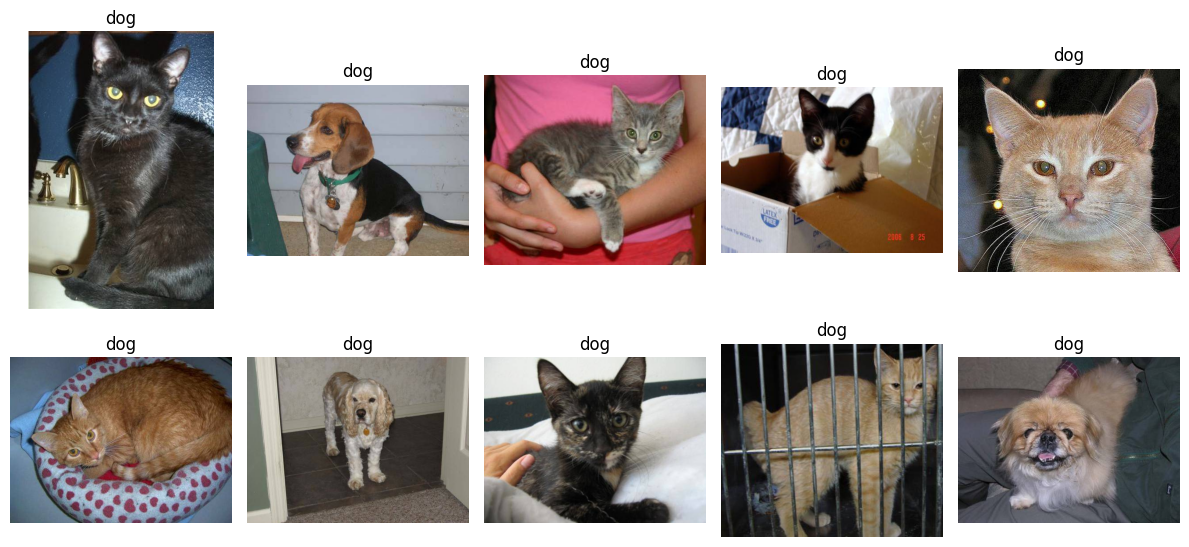

In [ ]:
# 모델 예측에 대한 결과 출력
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)